In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [3]:
!unzip -q lgg-mri-segmentation.zip -d ./lgg_mri_segmentation
!unzip -q brain-tumor-mri-dataset.zip -d ./brain_tumor_mri

In [4]:
import os
from glob import glob
import shutil

lgg_mri_path = "/content/lgg_mri_segmentation/lgg-mri-segmentation/kaggle_3m"
brain_tumor_train_path = "/content/brain_tumor_mri/Training"
brain_tumor_test_path = "/content/brain_tumor_mri/Testing"
combined_data_path = "/content/combined_data"

# Directories for combined dataset
os.makedirs(combined_data_path, exist_ok=True)
os.makedirs(f"{combined_data_path}/tumor", exist_ok=True)
os.makedirs(f"{combined_data_path}/non_tumor", exist_ok=True)

# Function to copy images into the new structure
def copy_images(source_path, dest_path, label):
    images = glob(f"{source_path}/**/*.jpg", recursive=True) + glob(f"{source_path}/**/*.png", recursive=True)
    for img in images:
        shutil.copy(img, f"{dest_path}/{label}/{os.path.basename(img)}")

# Copying images from both datasets
copy_images(lgg_mri_path, combined_data_path, "tumor")
copy_images(brain_tumor_train_path, combined_data_path, "tumor")
copy_images(brain_tumor_test_path, combined_data_path, "tumor")

# Number of images in each category
tumor_count = len(os.listdir(f"{combined_data_path}/tumor"))
non_tumor_count = len(os.listdir(f"{combined_data_path}/non_tumor"))

print(f"Tumor Images: {tumor_count}, Non-Tumor Images: {non_tumor_count}")

Tumor Images: 7023, Non-Tumor Images: 0


In [5]:
notumor_train_path = "/content/brain_tumor_mri/Training/notumor"
notumor_test_path = "/content/brain_tumor_mri/Testing/notumor"
non_tumor_dest = "/content/combined_data/non_tumor"

copy_images(notumor_train_path, "/content/combined_data", "non_tumor")
copy_images(notumor_test_path, "/content/combined_data", "non_tumor")

tumor_count = len(os.listdir(f"{combined_data_path}/tumor"))
non_tumor_count = len(os.listdir(f"{combined_data_path}/non_tumor"))

print(f"Updated Dataset - Tumor Images: {tumor_count}, Non-Tumor Images: {non_tumor_count}")

Updated Dataset - Tumor Images: 7023, Non-Tumor Images: 2000


In [6]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 256

processed_tumor_path = "/content/combined_data/tumor"
processed_nontumor_path = "/content/combined_data/non_tumor"

def preprocess_images(folder_path):
    images = os.listdir(folder_path)
    for img_name in tqdm(images, desc=f"Processing {folder_path}"):
        img_path = os.path.join(folder_path, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))       # Resize
        img = img / 255.0                                  # Normalize

        cv2.imwrite(img_path, (img * 255).astype(np.uint8))

preprocess_images(processed_tumor_path)
preprocess_images(processed_nontumor_path)

print("Image preprocessing complete!")

Processing /content/combined_data/non_tumor: 100%|██████████| 2000/2000 [00:02<00:00, 852.73it/s]

Image preprocessing complete!


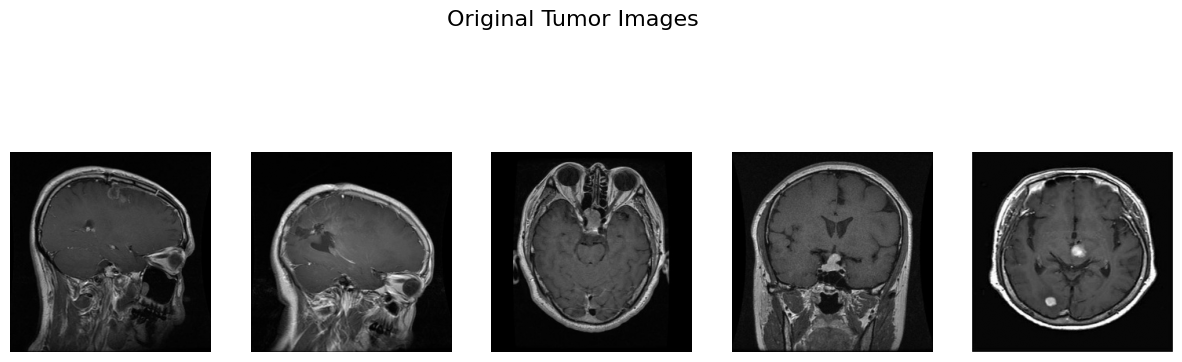

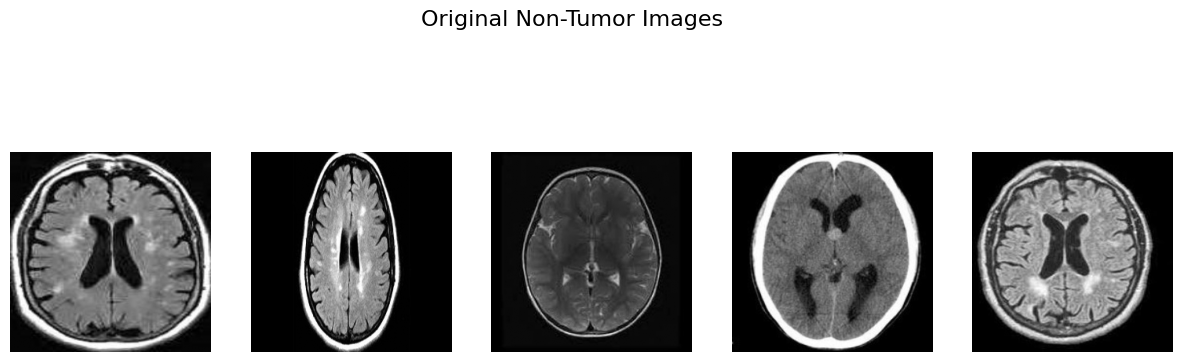

No generated images found. Train the GAN and save images for comparison.


In [7]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import os

tumor_path = "/content/combined_data/tumor"
non_tumor_path = "/content/combined_data/non_tumor"
generated_images_path = "/content/generated_images"  

def display_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img = cv2.imread(random.choice(image_paths), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

tumor_images = [os.path.join(tumor_path, img) for img in os.listdir(tumor_path)]
non_tumor_images = [os.path.join(non_tumor_path, img) for img in os.listdir(non_tumor_path)]
generated_images = [os.path.join(generated_images_path, img) for img in os.listdir(generated_images_path)] if os.path.exists(generated_images_path) else []

display_images(tumor_images, "Original Tumor Images")
display_images(non_tumor_images, "Original Non-Tumor Images")

if generated_images:
    display_images(generated_images, "Generated Images by GAN")
else:
    print("No generated images found. Train the GAN and save images for comparison.")

In [8]:
import cv2
import numpy as np
import os
import random

def basic_augment(img):
    # Random flip
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Random rotation
    angle = random.randint(-15, 15)
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    # Random brightness
    factor = random.uniform(0.8, 1.2)
    img = np.clip(img * factor, 0, 255).astype(np.uint8)

    return img

In [9]:
def balance_classes(tumor_dir, non_tumor_dir):
    tumor_imgs = os.listdir(tumor_dir)
    non_tumor_imgs = os.listdir(non_tumor_dir)

    if len(tumor_imgs) > len(non_tumor_imgs):
        src_dir = non_tumor_dir
        src_imgs = non_tumor_imgs
        target = len(tumor_imgs)
    elif len(tumor_imgs) < len(non_tumor_imgs):
        src_dir = tumor_dir
        src_imgs = tumor_imgs
        target = len(non_tumor_imgs)
    else:
        print("Dataset is already balanced.")
        return

    print(f"Augmenting {src_dir} to reach {target} images...")

    i = 0
    while len(os.listdir(src_dir)) < target:
        img_name = random.choice(src_imgs)
        img_path = os.path.join(src_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            aug_img = basic_augment(img)
            new_path = os.path.join(src_dir, f"aug_{i}_{img_name}")
            cv2.imwrite(new_path, aug_img)
            i += 1

    print("Augmentation complete.")

In [10]:
balance_classes("combined_data/tumor", "combined_data/non_tumor")

Augmenting combined_data/non_tumor to reach 7023 images...
Augmentation complete.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [12]:
def build_generator():
    def conv_block(x, filters, size=4, apply_batchnorm=True):
        x = layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False)(x)
        if apply_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x

    def deconv_block(x, skip, filters, size=4, dropout=False):
        x = layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        if dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.Activation('relu')(x)
        x = layers.Concatenate()([x, skip])
        return x

    inputs = layers.Input(shape=(256, 256, 1))

    # Encoder
    down1 = conv_block(inputs, 64, apply_batchnorm=False)  # (128x128)
    down2 = conv_block(down1, 128)  # (64x64)
    down3 = conv_block(down2, 256)  # (32x32)
    down4 = conv_block(down3, 512)  # (16x16)
    down5 = conv_block(down4, 512)  # (8x8)
    down6 = conv_block(down5, 512)  # (4x4)

    # Bottleneck
    bottleneck = conv_block(down6, 512)  # (2x2)

    # Decoder
    up1 = deconv_block(bottleneck, down6, 512, dropout=True)  # (4x4)
    up2 = deconv_block(up1, down5, 512, dropout=True)  # (8x8)
    up3 = deconv_block(up2, down4, 512)  # (16x16)
    up4 = deconv_block(up3, down3, 256)  # (32x32)
    up5 = deconv_block(up4, down2, 128)  # (64x64)
    up6 = deconv_block(up5, down1, 64)   # (128x128)

    last = layers.Conv2DTranspose(1, 4, strides=2, padding='same', activation='tanh')  # (256x256)

    outputs = last(up6)
    return Model(inputs, outputs, name="generator")

In [13]:
def build_discriminator():
    input_image = layers.Input(shape=(256, 256, 1), name='input_image')
    target_image = layers.Input(shape=(256, 256, 1), name='target_image')

    x = layers.Concatenate()([input_image, target_image])  # combine input and target

    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)  # Patch output

    return Model([input_image, target_image], x, name="discriminator")

In [14]:
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,024 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │        131,072 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        524,288 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,152 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 512)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 512)      │      4,194,304 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 8, 512)      │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 512)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 4, 512)      │      4,194,304 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 4, 4, 512)      │          2,048 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 41,832,705 (159.58 MB)

 Trainable params: 41,823,873 (159.55 MB)

 Non-trainable params: 8,832 (34.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 256, 256, 2)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 64)   │          2,112 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 64, 64, 128)    │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 32, 32, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 1)      │          4,097 │ leaky_re_lu_9[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 663,489 (2.53 MB)

 Trainable params: 662,721 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
import tensorflow as tf
import os
import cv2
import numpy as np

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 127.5 - 1  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=-1)  # Shape: (256, 256, 1)
    return img

In [18]:
def get_image_paths(folder):
    all_paths = []
    for subdir in ['tumor', 'non_tumor']:
        subfolder = os.path.join(folder, subdir)
        for filename in os.listdir(subfolder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                all_paths.append(os.path.join(subfolder, filename))
    return all_paths

def create_dataset(image_paths, batch_size=8):
    def gen():
        for path in image_paths:
            img = load_image(path)
            yield img, img  # input = target = same image (self-enhancement)

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
        )
    )
    return dataset.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [19]:
image_paths = get_image_paths('/content/combined_data')
train_dataset = create_dataset(image_paths, batch_size=8)

In [20]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [21]:
import time

def train(dataset, epochs=20):
    for epoch in range(epochs):
        start = time.time()

        print(f"\nEpoch {epoch+1}/{epochs}")
        for step, (input_image, target) in enumerate(dataset):
            gen_loss, disc_loss = train_step(input_image, target)

            if step % 10 == 0:
                print(f"Step {step}: Gen Loss = {gen_loss.numpy():.4f}, Disc Loss = {disc_loss.numpy():.4f}")

        print(f"Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec")

In [22]:
EPOCHS = 20
train(train_dataset, epochs=EPOCHS)


Epoch 1/20
Step 0: Gen Loss = 58.1657, Disc Loss = 1.6700
Step 10: Gen Loss = 20.2916, Disc Loss = 1.2688
Step 20: Gen Loss = 12.3811, Disc Loss = 1.4629
Step 30: Gen Loss = 11.3813, Disc Loss = 1.3617
Step 40: Gen Loss = 8.8138, Disc Loss = 1.3745
Step 50: Gen Loss = 10.0493, Disc Loss = 1.3719
Step 60: Gen Loss = 10.9655, Disc Loss = 1.2295
Step 70: Gen Loss = 7.1914, Disc Loss = 1.4805
Step 80: Gen Loss = 6.4504, Disc Loss = 1.3444
Step 90: Gen Loss = 4.6574, Disc Loss = 1.3725
Step 100: Gen Loss = 4.0254, Disc Loss = 1.3688
Step 110: Gen Loss = 5.6876, Disc Loss = 1.4009
Step 120: Gen Loss = 4.9535, Disc Loss = 1.3870
Step 130: Gen Loss = 4.3346, Disc Loss = 1.3533
Step 140: Gen Loss = 4.6023, Disc Loss = 1.4101
Step 150: Gen Loss = 3.8435, Disc Loss = 1.3605
Step 160: Gen Loss = 4.6418, Disc Loss = 1.3339
Step 170: Gen Loss = 7.7827, Disc Loss = 1.3958
Step 180: Gen Loss = 3.5645, Disc Loss = 1.3908
Step 190: Gen Loss = 4.4116, Disc Loss = 1.3446
Step 200: Gen Loss = 3.4596, Disc

In [24]:
generator.save('/content/enhancer_generator_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


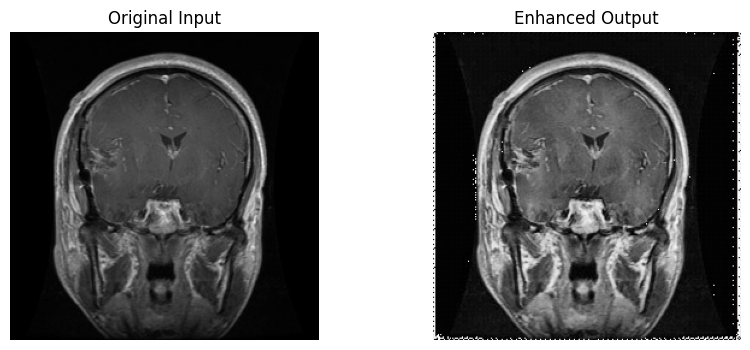

In [29]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Saving generator model
generator = load_model('/content/enhancer_generator_model.keras')

test_path = '/content/combined_data/tumor/Te-gl_0038.jpg'  
test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (256, 256)) / 255.0
test_img_input = np.expand_dims(test_img, axis=(0, -1))  # shape: (1, 256, 256, 1)

enhanced_img = generator.predict(test_img_input)[0]  # shape: (256, 256, 1)

enhanced_img_uint8 = (enhanced_img[:, :, 0] * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_clahe = clahe.apply(enhanced_img_uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Input')
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced Output')
plt.imshow(enhanced_clahe, cmap='gray')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


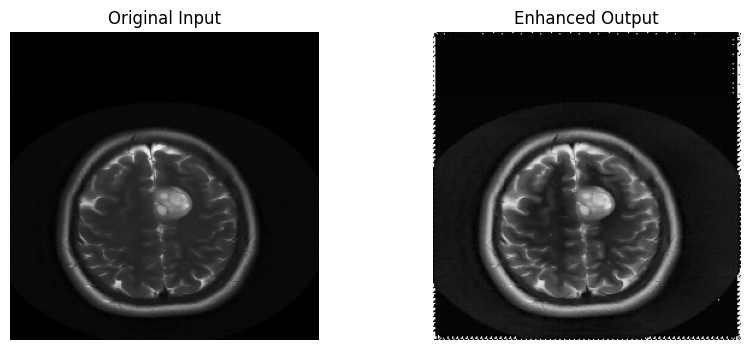

In [30]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

generator = load_model('/content/enhancer_generator_model.keras')

test_path = '/content/Screenshot 2025-04-08 230928.jpg'  
test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (256, 256)) / 255.0
test_img_input = np.expand_dims(test_img, axis=(0, -1))  # shape: (1, 256, 256, 1)

enhanced_img = generator.predict(test_img_input)[0]  # shape: (256, 256, 1)

enhanced_img_uint8 = (enhanced_img[:, :, 0] * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_clahe = clahe.apply(enhanced_img_uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Input')
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced Output')
plt.imshow(enhanced_clahe, cmap='gray')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


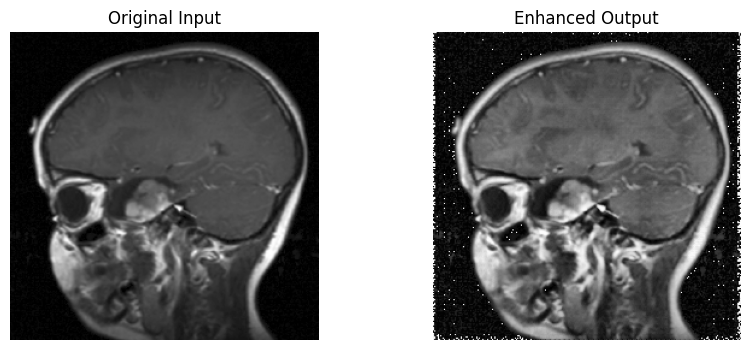

In [31]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

generator = load_model('/content/enhancer_generator_model.keras')

test_path = '/content/Screenshot 2025-04-08 231659.jpg'  
test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (256, 256)) / 255.0
test_img_input = np.expand_dims(test_img, axis=(0, -1))  # shape: (1, 256, 256, 1)

enhanced_img = generator.predict(test_img_input)[0]  # shape: (256, 256, 1)

enhanced_img_uint8 = (enhanced_img[:, :, 0] * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_clahe = clahe.apply(enhanced_img_uint8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Input')
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Enhanced Output')
plt.imshow(enhanced_clahe, cmap='gray')
plt.axis('off')
plt.show()


Evolutionary Strategy for GAN Hyperparameter Tuning

In [33]:
import numpy as np

param_bounds = {
    'learning_rate': [1e-5, 1e-3],
    'dropout_rate': [0.0, 0.5],
    'filters': [32, 128],  
    'kernel_size': [3, 7]  
}

In [34]:
def create_generator(filters, kernel_size, dropout_rate):
    inputs = tf.keras.Input(shape=(256, 256, 1))
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(1, (kernel_size, kernel_size), padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

In [35]:
def evaluate_fitness(params):
    filters = int(params[0])
    kernel_size = int(params[1])
    dropout_rate = float(params[2])
    lr = float(params[3])

    generator = create_generator(filters, kernel_size, dropout_rate)
    generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mae')

    history = generator.fit(train_images, train_targets, epochs=1, batch_size=8, verbose=0)
    loss = history.history['loss'][0]

    return -loss  

In [39]:
import cv2
import numpy as np
import os

input_folder = '/content/combined_data/non_tumor' 

def load_input_images(n=10):
    input_images = []
    filenames = sorted(os.listdir(input_folder))[:n]

    for fname in filenames:
        img = cv2.imread(os.path.join(input_folder, fname), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (256, 256)) / 255.0
        input_images.append(img[..., np.newaxis])

    return np.array(input_images)

fixed_inputs = load_input_images()
print(" Loaded fixed input sample:", fixed_inputs.shape)


 Loaded fixed input sample: (10, 256, 256, 1)


In [40]:
def evaluate_fitness(params):
    filters, kernel_size, dropout = params

    generator = build_generator(filters=filters, kernel_size=kernel_size, dropout=dropout)

    generator.compile(optimizer='adam', loss='mae')
    generator.fit(fixed_inputs, fixed_inputs, epochs=1, batch_size=4, verbose=0)

    generated = generator.predict(fixed_inputs, verbose=0)

    loss = np.mean(np.abs(fixed_inputs - generated))
    fitness = 1 / (loss + 1e-6)
    return fitness


In [41]:
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, Model

input_folder = '/content/combined_data/non_tumor'

def load_input_images(n=10):
    input_images = []
    filenames = sorted(os.listdir(input_folder))[:n]
    for fname in filenames:
        img = cv2.imread(os.path.join(input_folder, fname), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (256, 256)) / 255.0
        input_images.append(img[..., np.newaxis])
    return np.array(input_images)

fixed_inputs = load_input_images()
print(" Loaded fixed input sample:", fixed_inputs.shape)

def build_generator(filters=64, kernel_size=3, dropout=0.3):
    inputs = layers.Input(shape=(256, 256, 1))

    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(filters * 2, kernel_size, activation='relu', padding='same')(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = layers.Conv2D(1, kernel_size, activation='sigmoid', padding='same')(x)

    return Model(inputs, x)

def evaluate_fitness(params):
    filters, kernel_size, dropout = params
    generator = build_generator(filters, kernel_size, dropout)
    generator.compile(optimizer='adam', loss='mae')

    # 1 epoch quick training
    generator.fit(fixed_inputs, fixed_inputs, epochs=1, batch_size=4, verbose=0)

    generated = generator.predict(fixed_inputs, verbose=0)
    loss = np.mean(np.abs(fixed_inputs - generated))  # MAE loss
    fitness = 1 / (loss + 1e-6)  

    return fitness

population_size = 6
generations = 3
mutation_rate = 0.3

# Initial population: [filters, kernel_size, dropout]
population = [
    [random.choice([32, 64, 128]),
     random.choice([3, 5]),
     random.uniform(0.1, 0.5)]
    for _ in range(population_size)
]

for gen in range(generations):
    print(f"\n Generation {gen + 1}")
    fitness_scores = []

    for individual in population:
        score = evaluate_fitness(individual)
        fitness_scores.append((score, individual))
        print(f"  Params: {individual} → Fitness: {score:.4f}")

    # Sort by fitness
    fitness_scores.sort(reverse=True)
    best_individuals = [ind for _, ind in fitness_scores[:2]]

    # Breed new population
    new_population = best_individuals[:]
    while len(new_population) < population_size:
        parent = random.choice(best_individuals)
        child = parent.copy()

        # Apply mutation
        if random.random() < mutation_rate:
            child[0] = random.choice([32, 64, 128])  # filters
        if random.random() < mutation_rate:
            child[1] = random.choice([3, 5])  # kernel size
        if random.random() < mutation_rate:
            child[2] = min(max(child[2] + random.uniform(-0.1, 0.1), 0.1), 0.5)  # dropout
        new_population.append(child)

    population = new_population

print("\n Evolution complete!")
print(" Best Hyperparameters Found:", fitness_scores[0][1])


 Loaded fixed input sample: (10, 256, 256, 1)

 Generation 1
  Params: [32, 5, 0.18401087153396722] → Fitness: 2.9993
  Params: [32, 5, 0.452947418083979] → Fitness: 3.0078
  Params: [32, 5, 0.22948807206962615] → Fitness: 2.9769
  Params: [128, 5, 0.1026739798771803] → Fitness: 3.8971


  Params: [32, 3, 0.4146053331251002] → Fitness: 2.9937


  Params: [32, 3, 0.19804285846224792] → Fitness: 2.9530

 Generation 2
  Params: [128, 5, 0.1026739798771803] → Fitness: 3.1460
  Params: [32, 5, 0.452947418083979] → Fitness: 3.0284
  Params: [32, 5, 0.1026739798771803] → Fitness: 2.9718
  Params: [32, 5, 0.452947418083979] → Fitness: 3.0154
  Params: [32, 5, 0.452947418083979] → Fitness: 2.9633
  Params: [32, 5, 0.40744045697367953] → Fitness: 3.0073

 Generation 3
  Params: [128, 5, 0.1026739798771803] → Fitness: 3.7846
  Params: [32, 5, 0.452947418083979] → Fitness: 3.0187
  Params: [128, 5, 0.1026739798771803] → Fitness: 3.8382
  Params: [64, 5, 0.12652069330583277] → Fitness: 3.0717
  Params: [64, 5, 0.1026739798771803] → Fitness: 3.0533
  Params: [32, 5, 0.4273763970619738] → Fitness: 3.0051

 Evolution complete!
 Best Hyperparameters Found: [128, 5, 0.1026739798771803]
